In [440]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import SearchIO
import csv
import sqlite3
import time
from multiprocessing import Pool, cpu_count
import sys
from calc_icity_ import *
import ast
from collections import defaultdict
import subprocess
import logomaker

## helper functions
def get_permissive_rep_(bait_pid):
def get_p90s(p30_id):
def get_p100s(p90_id):
def get_prot_sequence(pid):

'14bc66ab7912db1e07'

In [207]:
#### helper functions
def get_prot_sequence(pid):
    con = sqlite3.connect("80kprotein_stats.db")
    cur = con.cursor()
    cmd = "SELECT sequence FROM proteins WHERE pid = '%s'" % pid 
    #print(cmd)
    cur.execute(cmd)
    return str(cur.fetchone()[0])
    con.close()
def get_permissive_rep_(bait_pid):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    perm_rep = None
    cmd_p = "SELECT p30 FROM clusters WHERE p100 = '%s'" % (bait_pid)
    try:
        cursor.execute(cmd_p)
        perm_rep = cursor.fetchone()[0]
        conn.close()
        return(perm_rep)
    except:
        return "nan"

def get_p90s(p30_id):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd = "SELECT p90 FROM clusters WHERE p30 = '%s'" % (p30_id)
    cursor.execute(cmd)
    p90s = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(list(set(p90s)))

def get_p100s(p90_id):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd = "SELECT p100 FROM clusters WHERE p90 = '%s'" % (p90_id)
    cursor.execute(cmd)
    p100s = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(list(set(p100s)))

In [281]:
tnpbdir = "../tnpBs/dtnpB_highicity_anyresmut"
inpath_dtnpB_targets = "../ggdb_dfs/dTnpB_anymut_target_fetch.input.tsv"

In [283]:
dtnpB_hiicity_ids = []
dtnpB_targets_df = pd.read_csv(inpath_dtnpB_targets, sep = '\t')
dtnpB_series_p100 = dtnpB_targets_df["baitp100s"].apply(lambda x: ast.literal_eval(x))
for dtnpB_id_list in dtnpB_series_p100:
    dtnpB_hiicity_ids += dtnpB_id_list
dtnpB_hiicity_ids = list(set(dtnpB_hiicity_ids))
len(dtnpB_hiicity_ids)

2046

## get high icity tnpBs (p60s) to align

In [288]:
mmseqs_dir = tnpbdir
os.mkdir(mmseqs_dir)
mmseqs_in = mmseqs_dir + "/in_ids"

In [291]:
def cluster_(pid_inpath, mmseqs_dir, identity, pid_list = None):
    if pid_list != None:
        with open(pid_inpath, "w") as outfile:
            for pid in pid_list:
                print(pid, file=outfile)
    cmd = "python3 clustering_gen.py {} {} {}".format(pid_inpath, mmseqs_dir, identity)
    process = subprocess.Popen(cmd.split(' '))
    process.wait()
    output_tsv = mmseqs_dir + "/OUTPUT/_cluster.tsv"
    cluster_rep_df = pd.read_csv(output_tsv, sep = '\t').drop_duplicates()
    return list(set(cluster_rep_df.iloc[:,0]))

In [293]:
#dtnpB_hiicity_p60_ids = cluster_(mmseqs_in, mmseqs_dir, "0.6", dtnpB_hiicity_ids)
len(dtnpB_hiicity_p60_ids)

313

In [295]:
def p100_p60_cluster_dict(mmseqs_dir):
    cluster_dict = {}
    output_tsv = mmseqs_dir + "/OUTPUT/_cluster.tsv"
    cluster_rep_df = pd.read_csv(output_tsv, sep = '\t', header = None).drop_duplicates()
    for i in range(len(cluster_rep_df)):
        p60id = cluster_rep_df.iloc[i,0]
        p100id = cluster_rep_df.iloc[i,1]
        cluster_dict[p100id] = p60id
    return cluster_dict
p100_p60_dict = p100_p60_cluster_dict(mmseqs_dir)

def get_p60_rep(p100_list_str):
    p60_list = []
    p100_list = ast.literal_eval(p100_list_str)
    for p100 in p100_list:
        p60 = p100_p60_dict[p100]
        p60_list.append(p60)
    return str(p60_list)

def get_p30_rep(p100_list_str):
    p30_list = []
    p100_list = ast.literal_eval(p100_list_str)
    for p100 in p100_list:
        p30 = get_permissive_rep_(p100)
        p30_list.append(p30)
    return str(p30_list)

In [296]:
dtnpB_targets_df["baitp60s"] = dtnpB_targets_df["baitp100s"].apply(lambda x: get_p60_rep(x))
dtnpB_targets_df["baitp60s_uniq"] = dtnpB_targets_df["baitp100s"].apply(lambda x: str(list(set(ast.literal_eval(get_p60_rep(x))))))
dtnpB_targets_df["baitp30s_uniq"] = dtnpB_targets_df["baitp100s"].apply(lambda x: str(list(set(ast.literal_eval(get_p30_rep(x))))))

### run alignments and get catalytically inactive tnpBs

In [297]:
infile_mafft = tnpbdir + "/mafft_input.p60.faa"
outfile_mafft = tnpbdir + "/mafft_output.p60.faa"
infile_mafft_all = tnpbdir + "/mafft_input.p100.faa"
outfile_mafft_all = tnpbdir + "/mafft_output.p100.faa"

In [298]:
def get_prot_sequence(pid):
    con=sqlite3.connect("80kprotein_stats.db")
    cur = con.cursor()
    cmd = "SELECT sequence FROM proteins WHERE pid = '%s'" % pid 
    #print(cmd)
    cur.execute(cmd)
    return str(cur.fetchone()[0])
    con.close()

In [299]:
'd396977bf919235181' in dtnpB_hiicity_p60_ids

True

In [302]:
def get_multifaa_protidlist(protidlist, outpath):
    with open(outpath, "w") as outfile:
        for protid in protidlist:
            protseq = get_prot_sequence(protid)
            if len(protseq) > 300 and len(protseq) < 500:
                print(">" + protid, file=outfile)
                print(protseq, file=outfile)
#get_multifaa_protidlist(dtnpB_hiicity_p60_ids + ["0fea0aedf485f57c86"], infile_mafft)
#get_multifaa_protidlist(dtnpB_hiicity_ids + ["0fea0aedf485f57c86"], infile_mafft_all)

In [301]:
cmd_mafft = "ginsi --thread 32 " + infile_mafft + " > " + outfile_mafft
print("running mafft ginsi: " + cmd_mafft)
os.system(cmd_mafft)

running mafft ginsi: ginsi --thread 32 ../tnpBs/dtnpB_highicity_anyresmut/mafft_input.p60.faa > ../tnpBs/dtnpB_highicity_anyresmut/mafft_ouput.p60.faa


sh: 1: ginsi: not found


32512

In [ ]:
cmd_mafft = "ginsi --thread 32 " + infile_mafft_all + " > " + outfile_mafft_all
print("running mafft ginsi: " + cmd_mafft)
os.system(cmd_mafft)
asdf

In [303]:
ref_tnpB_pid = '0fea0aedf485f57c86'
ref_seq = get_prot_sequence(ref_tnpB_pid)
ref_seq[187], ref_seq[271], ref_seq[354]

('D', 'E', 'D')

In [306]:
def get_alignindices_dict(ref_tnpB_pid, msa_file):
    # get seq1, which is the amino acid fasta format for ref_tnpB_pid
    seq1 = get_prot_sequence(ref_tnpB_pid)
    # get seq2, which is the amino acid fasta format with gaps, post-alignment
    with open(msa_file) as handle:
        for rec in SeqIO.parse(handle, 'fasta'):
            pid = rec.id
            if pid == ref_tnpB_pid:
                seq2 = str(rec.seq)
                break
    # map the indices of amino acids between the two sequence formats
    index_to_alignindex = {}
    align_indexes = []
    for i in range(len(seq2)):
        char = seq2[i]
        if char != '-':
            align_indexes.append(i)
    for j in range(len(align_indexes)):
        index_to_alignindex[j] = align_indexes[j]
    return index_to_alignindex

align_indices_dict = get_alignindices_dict(ref_tnpB_pid, outfile_mafft)
align_indices_big_dict = get_alignindices_dict(ref_tnpB_pid, outfile_mafft_all)

Text(0, 0.5, 'frequency')

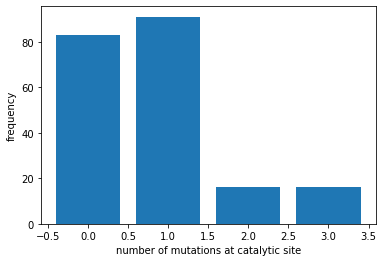

In [452]:
plt.bar([0, 1, 2, 3], [list(p60id_numresmut.values()).count(i) for i in [0, 1, 2, 3]])
plt.xlabel("number of mutations at catalytic site")
plt.ylabel("frequency")

In [362]:
p60id_allresmut = {}
p60id_numresmut = {}
seq_logo_list_p60 = []
seq_logo_list_p100 = []

with open(outfile_mafft) as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        d1, e2, d3 = 0,0,0
        p60_id = rec.id
        #if p60_id == ref_tnpB_pid:
        p60_seq = rec.seq
        residues = [p60_seq[align_indices_dict[187]], p60_seq[align_indices_dict[271]], p60_seq[align_indices_dict[354]]]
        if residues[0] == "D":
            d1 += 1
        if residues[1] == "E":
            e2 += 1
        if residues[2] == "D":
            d3 += 1
        seq_logo_list_p60 += [residues]
        p60id_allresmut[p60_id] = sum([d1, e2, d3]) == 0
        p60id_numresmut[p60_id] = 3 - sum([d1, e2, d3])
        
p100id_allresmut = {}
p100id_numresmut = {}
with open(outfile_mafft_all) as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        d1, e2, d3 = 0,0,0
        p100_id = rec.id
        #if p60_id == ref_tnpB_pid:
        p100_seq = rec.seq
        residues = [p100_seq[align_indices_big_dict[187]], p100_seq[align_indices_big_dict[271]], p100_seq[align_indices_big_dict[354]]]
        if residues[0] == "D":
            d1 += 1
        if residues[1] == "E":
            e2 += 1
        if residues[2] == "D":
            d3 += 1
        seq_logo_list_p100 += [residues]
        p100id_allresmut[p100_id] = sum([d1, e2, d3]) == 0
        p100id_numresmut[p100_id] = 3 - sum([d1, e2, d3])

In [455]:
p100_seqlogo_raw_df = pd.DataFrame(seq_logo_list_p60)
p100_resid_1_freq_df = pd.DataFrame(pd.get_dummies(p100_seqlogo_raw_df.iloc[:, 0]).mean())
p100_resid_2_freq_df = pd.DataFrame(pd.get_dummies(p100_seqlogo_raw_df.iloc[:, 1]).mean())#.rename(columns={'0':'1'})
p100_resid_3_freq_df = pd.DataFrame(pd.get_dummies(p100_seqlogo_raw_df.iloc[:, 2]).mean())#.rename(columns={'0':'1'})
p100_seqlogo_freq_df = pd.concat([p100_resid_1_freq_df, p100_resid_2_freq_df, p100_resid_3_freq_df], axis = 1).fillna(0)
p100_seqlogo_freq_df.columns = [1, 2, 3]
p100_seqlogo_freq_df = p100_seqlogo_freq_df.transpose()
p100_resid_1_freq_df.iloc[:,0].sort_values(ascending=False), \
p100_resid_2_freq_df.iloc[:,0].sort_values(ascending=False), \
p100_resid_3_freq_df.iloc[:,0].sort_values(ascending=False)

(D    0.864078
 S    0.043689
 A    0.024272
 P    0.019417
 G    0.009709
 I    0.009709
 T    0.009709
 -    0.004854
 E    0.004854
 K    0.004854
 L    0.004854
 Name: 0, dtype: float64,
 E    0.524272
 G    0.325243
 A    0.043689
 S    0.019417
 V    0.019417
 -    0.014563
 P    0.014563
 Q    0.014563
 I    0.009709
 K    0.004854
 L    0.004854
 T    0.004854
 Name: 0, dtype: float64,
 D    0.781553
 -    0.116505
 G    0.029126
 Q    0.029126
 H    0.014563
 L    0.009709
 A    0.004854
 E    0.004854
 N    0.004854
 T    0.004854
 Name: 0, dtype: float64)

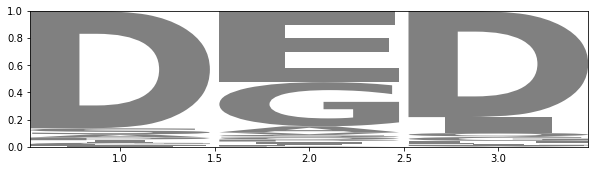

In [456]:
crp_logo = logomaker.Logo(p100_seqlogo_freq_df)
crp_logo

In [308]:
len(p60id_numresmut), len(p100id_allresmut)

(206, 1415)

In [309]:
def all_res_mut(p60id_liststr, p60id_allresmut_dict):
    rv = []
    p60id_list = ast.literal_eval(p60id_liststr)
    for p60id in p60id_list:
        try:
            all_res_mut = p60id_allresmut_dict[p60id]
            rv.append(all_res_mut)
        except:
            #p60 got removed during alignment, most likely falls outside the 300-500 aa size range
            rv.append(np.nan)
    return rv
def numresmut(p60id_liststr, p60id_numresmut_dict):
    rv = []
    p60id_list = ast.literal_eval(p60id_liststr)
    for p60id in p60id_list:
        try:
            all_res_mut = p60id_numresmut_dict[p60id]
            rv.append(all_res_mut)
        except:
            #p60 got removed during alignment, most likely falls outside the 300-500 aa size range
            rv.append(np.nan)
    return rv
def len_proteins(pid_liststr):
    rv = []
    pid_list = ast.literal_eval(pid_liststr)
    for pid in pid_list:
        try:
            len_protein = len(get_prot_sequence(pid))
            rv.append(len_protein)
        except:
            #p60 got removed during alignment, most likely falls outside the 300-500 aa size range
            rv.append(np.nan)
    return rv

In [310]:
dtnpB_targets_df["p60_all_res_mut"] = dtnpB_targets_df["baitp60s_uniq"].apply(lambda x: all_res_mut(x, p60id_allresmut))
dtnpB_targets_df["p60_num_res_mut"] = dtnpB_targets_df["baitp60s_uniq"].apply(lambda x: all_res_mut(x, p60id_numresmut))
dtnpB_targets_df["p100_num_res_mut"] = dtnpB_targets_df["baitp100s"].apply(lambda x: all_res_mut(x, p100id_numresmut))
dtnpB_targets_df["p60_len"] = dtnpB_targets_df["baitp60s_uniq"].apply(lambda x: len_proteins(x))

In [331]:
dtnpB_targets_df_lenfiltered = dtnpB_targets_df[dtnpB_targets_df["p100_num_res_mut"].apply(lambda x: x.count(np.nan)/len(x) < .2)]
dtnpB_targets_df_filtered = dtnpB_targets_df_lenfiltered[dtnpB_targets_df_lenfiltered["p60_num_res_mut"].apply(lambda x: x.count(0) / len(x) < .2)]

In [337]:
dtnpB_targets_df.to_csv("../ggdb_dfs/dTnpB_anymut_target_analysis.tsv", sep = '\t', index = False)

In [338]:
dtnpB_targets_df_filtered.to_csv("../ggdb_dfs/dTnpB_anymut_target_analysis.filtered.tsv", sep = '\t', index = False)

In [334]:
len(dtnpB_targets_df), len(dtnpB_targets_df_lenfiltered), len(dtnpB_targets_df_filtered)

(91, 52, 28)

In [163]:
"c1050b21cc75640d51, 04bbfb58c48a0e8a29, 260273e052f76dffd2, c7de21b826534e1702, aa6af7e9289c3558d3, c7a1b8f01c5b7c48a2, 0a3217e07a25d0cbe0,  214319fd8cc31efee9, 7c8d22120719f2db6d, a0d79afeb20bd32508, d90f25484d732aa877".split(",")

['c1050b21cc75640d51',
 ' 04bbfb58c48a0e8a29',
 ' 260273e052f76dffd2',
 ' c7de21b826534e1702',
 ' aa6af7e9289c3558d3',
 ' c7a1b8f01c5b7c48a2',
 ' 0a3217e07a25d0cbe0',
 '  214319fd8cc31efee9',
 ' 7c8d22120719f2db6d',
 ' a0d79afeb20bd32508',
 ' d90f25484d732aa877']

In [214]:
# target genes near baits missing all 3 cat residues and within protein length range
target_p30_deadbaits = ['9038f7993863bcadca', '6bf6c4c7da68779d7a', 'd862301d73972ea41c', '2a89c5bbdcfcb0cd2a', 
                        '23422406293d40c201', 'c1050b21cc75640d51', '04bbfb58c48a0e8a29', '260273e052f76dffd2',
                        'c7de21b826534e1702', 'aa6af7e9289c3558d3', 'c7a1b8f01c5b7c48a2', '0a3217e07a25d0cbe0',
                        '214319fd8cc31efee9', '7c8d22120719f2db6d', 'a0d79afeb20bd32508', 'd90f25484d732aa877']

In [278]:
list(dtnpB_targets_df_lenfiltered['target_p30id'])

26

In [116]:
d1, e2, d3 = 0,0,0
with open(outfile_mafft) as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        p60_id = rec.id
        #if p60_id == ref_tnpB_pid:
        p60_seq = rec.seq
        residues = (p60_seq[align_indices_dict[187]], p60_seq[align_indices_dict[271]], p60_seq[align_indices_dict[354]])
        if residues[0] == "D":
            d1 += 1
        if residues[1] == "E":
            e2 += 1
        if residues[2] == "D":
            d3 += 1
d1, e2, d3

(10, 4, 11)

In [115]:
d1, e2, d3 = 0,0,0
with open(outfile_mafft_all) as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        p100_id = rec.id
        if p100_id in set(dtnpB_hiicity_p60_ids):
            p60_seq = rec.seq
            residues = (p60_seq[align_indices_big_dict[187]], p60_seq[align_indices_big_dict[271]], p60_seq[align_indices_big_dict[354]])
            if residues[0] == "D":
                d1 += 1
            if residues[1] == "E":
                e2 += 1
            if residues[2] == "D":
                d3 += 1
d1, e2, d3

(9, 5, 8)

## Connect hits back to phylogenetic tree

In [176]:
tree_p60_dtnpBs = ['1e8004b9ed6334203a',  'ce6458e7937be732d1', '3fff8120bed11c0a3d',  'db3ad769e574f02606',
'fba0795fae4cf2b899',  '16bcdfc9dbe27375ce',  'b2d60aa00edc0ff328',  '8c1c38079e7d3951bd',
'6f148253df15481f8b',
'db837fd13b790cdecc', '127d6d664652909143', '8be4199a7b3eb07fd5',  '4dd8d5ee06e88251ba',  '51b95557c560b36205',
'aad6dc7b6c362a1dc6', 'a53ecf027356cce68d',  'ccb1767618eda947d9'
'9f7ed5e63d7924cb4f']



In [179]:
[get_permissive_rep_(tnpBid) for tnpBid in tree_p60_dtnpBs]

['d0ff02f989caa4bfe6',
 '888509f038f9be7bf9',
 '888509f038f9be7bf9',
 '888509f038f9be7bf9',
 '38791f2467dc1b2388',
 '018da5f0a53659b734',
 '38791f2467dc1b2388',
 '38791f2467dc1b2388',
 '90f0ed1fef9b9987db',
 '894a0679fdb57b0802',
 '894a0679fdb57b0802',
 '894a0679fdb57b0802',
 'e1c939cb19e77c88ee',
 '33e6d85b815cbe55e5',
 '993ea08c331aa195bb',
 '4ca2541634b8270ca0',
 'nan']

In [202]:
bait_p30s_set = set()
for i in range(len(dtnpB_targets_df["baitp30s_uniq"])):
    bait_p30s_set.update(ast.literal_eval(dtnpB_targets_df["baitp30s_uniq"][i]))

In [203]:
set(['d0ff02f989caa4bfe6',
 '888509f038f9be7bf9',
 '888509f038f9be7bf9',
 '888509f038f9be7bf9',
 '38791f2467dc1b2388',
 '018da5f0a53659b734',
 '38791f2467dc1b2388',
 '38791f2467dc1b2388',
 '90f0ed1fef9b9987db',
 '894a0679fdb57b0802',
 '894a0679fdb57b0802',
 '894a0679fdb57b0802',
 'e1c939cb19e77c88ee',
 '33e6d85b815cbe55e5',
 '993ea08c331aa195bb',
 '4ca2541634b8270ca0',
 'nan']).intersection(bait_p30s_set)

{'018da5f0a53659b734',
 '33e6d85b815cbe55e5',
 '38791f2467dc1b2388',
 '4ca2541634b8270ca0',
 '888509f038f9be7bf9',
 '894a0679fdb57b0802',
 '90f0ed1fef9b9987db',
 '993ea08c331aa195bb',
 'd0ff02f989caa4bfe6',
 'e1c939cb19e77c88ee'}